# 04. PyTorch Custom Datasets

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and custom data loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [4]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

Our dataset is a subset of the FOod101 dataset.

Food 101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment

In [5]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
                            
    print(f"Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [6]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

The image path: data\pizza_steak_sushi\train\sushi\2004525.jpg
Class label: sushi
Image height: 512
Image width: 512


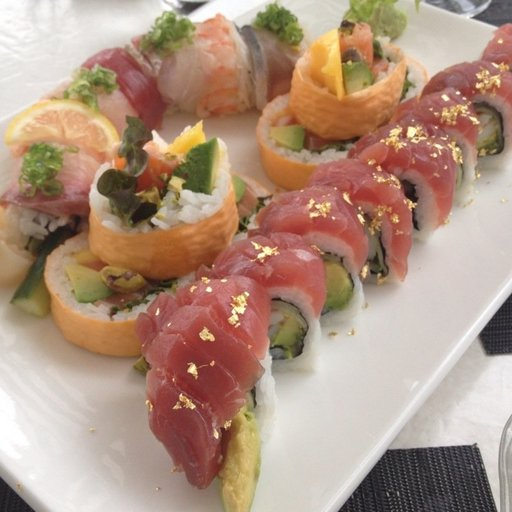

In [9]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(f"The image path: {random_image_path}")

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
print(f"Class label: {image_class}")

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

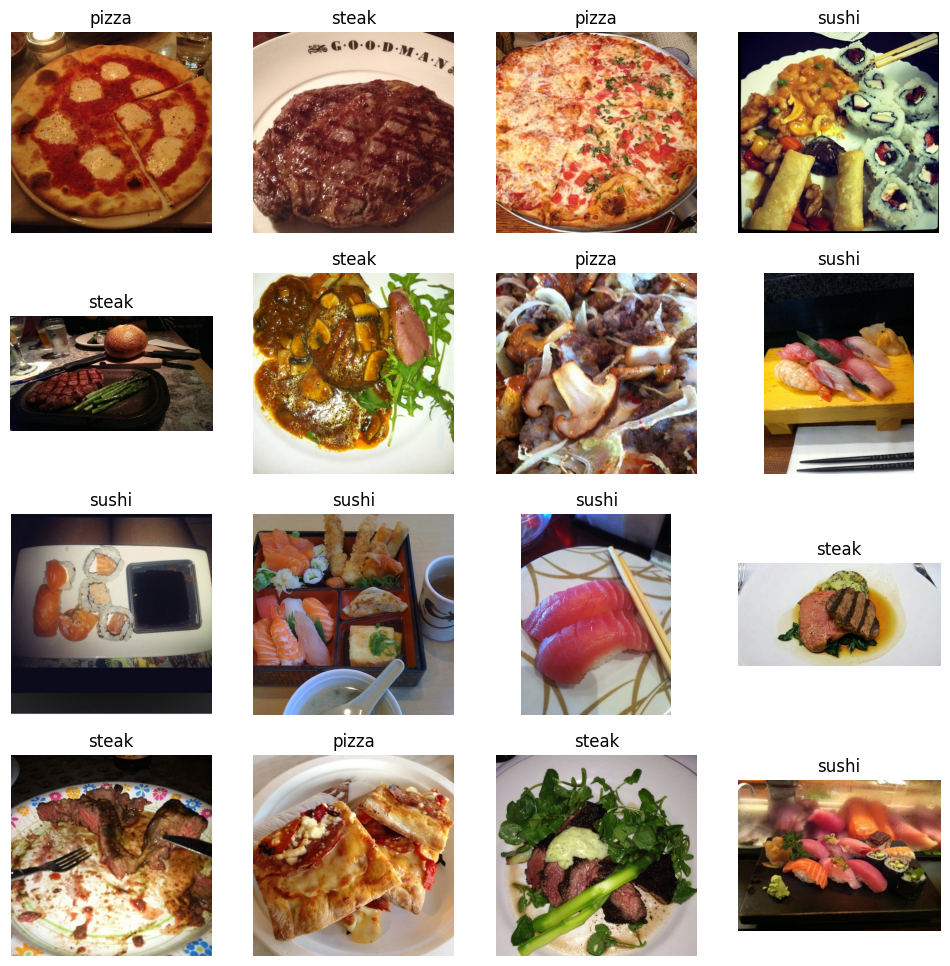

In [10]:
# Try to visualize an image with matplotlib by myself
import matplotlib.pyplot as plt
import numpy as np

# Get all image paths 
image_path_list = list(image_path.glob("train/*/*.jpg"))

nrows = 4
ncols = 4

plt.figure(figsize=(12, 12))
for i in range(1, nrows*ncols+1):
    random_image_path = random.choice(image_path_list)
    img = Image.open(random_image_path)

    plt.subplot(nrows, ncols, i)
    plt.imshow(img)
    plt.title(random_image_path.parent.stem)
    plt.axis(False)


(np.float64(-0.5), np.float64(511.5), np.float64(381.5), np.float64(-0.5))

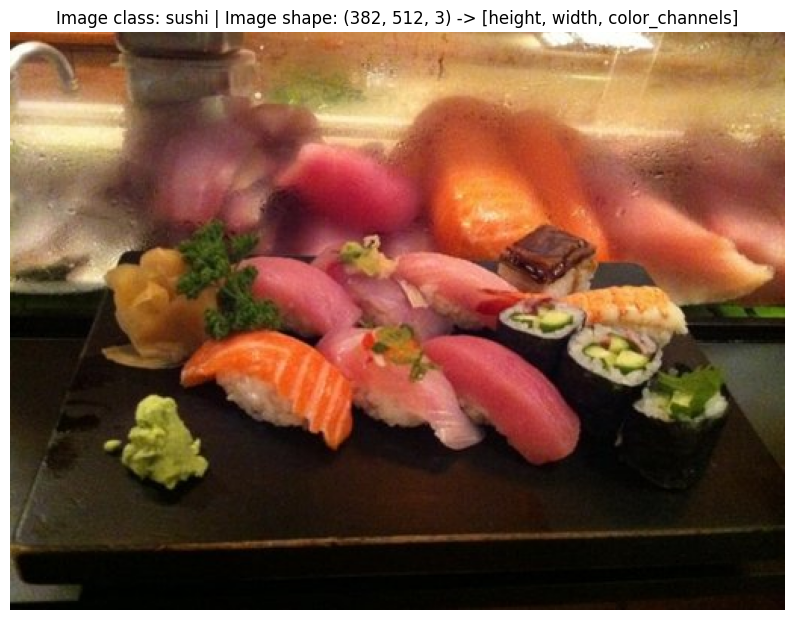

In [11]:
# Turn the image into an array (this is the video's way of doing it)
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [12]:
img_as_array

array([[[146,  83,  32],
        [143,  80,  29],
        [145,  79,  29],
        ...,
        [106,  68,  45],
        [107,  70,  51],
        [116,  79,  60]],

       [[143,  77,  27],
        [142,  76,  26],
        [141,  75,  25],
        ...,
        [110,  72,  49],
        [105,  69,  47],
        [104,  67,  48]],

       [[143,  75,  26],
        [143,  75,  26],
        [142,  74,  27],
        ...,
        [116,  78,  55],
        [110,  74,  52],
        [104,  68,  46]],

       ...,

       [[  3,   3,   1],
        [  3,   3,   1],
        [  2,   2,   0],
        ...,
        [ 18,   4,   1],
        [ 18,   4,   1],
        [ 18,   4,   1]],

       [[  3,   3,   3],
        [  2,   2,   2],
        [  2,   2,   2],
        ...,
        [ 19,   5,   2],
        [ 19,   5,   2],
        [ 19,   5,   2]],

       [[  3,   3,   3],
        [  4,   4,   4],
        [  4,   4,   4],
        ...,
        [ 21,   7,   4],
        [ 20,   6,   3],
        [ 19,   5,   2]]

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images.)
2. Turn it into a `torch.utils.data.Datset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`

In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation

In [14]:
# Write a transform for an image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [15]:
# Turned our PIL image into a tensor
data_transform(img)

tensor([[[0.5176, 0.5725, 0.5961,  ..., 0.5059, 0.5333, 0.5020],
         [0.5961, 0.8118, 0.7176,  ..., 0.5686, 0.5686, 0.5451],
         [0.9176, 0.7098, 0.5333,  ..., 0.6078, 0.5882, 0.5961],
         ...,
         [0.3843, 0.3137, 0.2549,  ..., 0.0471, 0.0431, 0.0431],
         [0.3529, 0.3333, 0.3020,  ..., 0.0706, 0.0706, 0.0667],
         [0.0980, 0.0824, 0.0706,  ..., 0.0824, 0.0863, 0.0784]],

        [[0.2588, 0.3020, 0.3255,  ..., 0.3843, 0.4039, 0.3569],
         [0.4980, 0.7216, 0.5647,  ..., 0.4392, 0.4392, 0.4039],
         [0.9020, 0.6471, 0.4196,  ..., 0.4706, 0.4510, 0.4549],
         ...,
         [0.3765, 0.2902, 0.2314,  ..., 0.0314, 0.0314, 0.0314],
         [0.3529, 0.3216, 0.2824,  ..., 0.0392, 0.0353, 0.0275],
         [0.0980, 0.0824, 0.0667,  ..., 0.0392, 0.0392, 0.0275]],

        [[0.1020, 0.1490, 0.1490,  ..., 0.2118, 0.2471, 0.2431],
         [0.4196, 0.6392, 0.4510,  ..., 0.2667, 0.2667, 0.2549],
         [0.8627, 0.5882, 0.3333,  ..., 0.2784, 0.2549, 0.

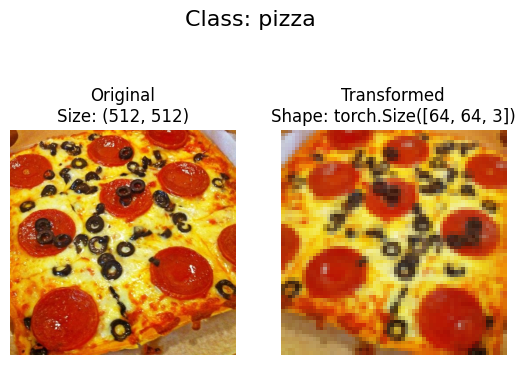

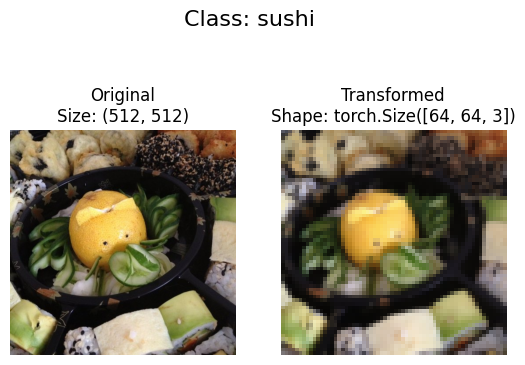

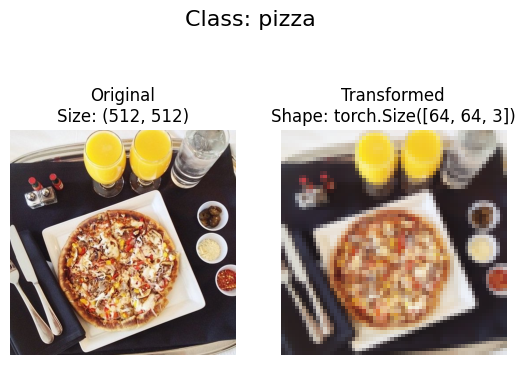

In [16]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms 
    them the nplots the original vs the transformed version
    """
    if seed:
        random.seed(seed)
    
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f) # note we will need to change shape for matplotlib
            transformed_image = transformed_image.permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=0)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [17]:
# Use ImageFolder to create datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
# Get class names as list
class_names = train_data.classes
print(class_names)

# Get class names as dictionary
class_dict = train_data.class_to_idx
print(class_dict)

# Check the lengths of our dataset
print(f"Length train data: {len(train_data)}\nLength test data: {len(test_data)}")

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
Length train data: 225
Length test data: 75


In [19]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [20]:
# Index on the train_data Dataest to get a single image and label
img, label = train_data[0]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

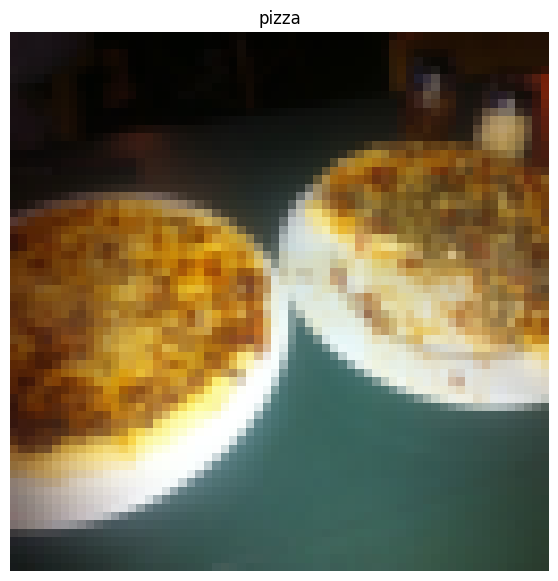

In [21]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(7, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label])

## 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time

In [22]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1ae561e5be0>,
 <torch.utils.data.dataloader.DataLoader at 0x1ae4963e5a0>)

In [23]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [24]:
img, label = next(iter(train_dataloader))
# Batch wize will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean that it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

In [25]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [27]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Finds the class folder names in a target directory.
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory} please check file structure")
    
    # 3. Create a dictionary of index labels (Computers prefer numbers rather than srings as labels)
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len__()` method to return the length of the dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed an index

In [30]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, targ_dir: str, transform=None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transform
        self.transforms = transform
        # Create clsses and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it"
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite the __len__()
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__()
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)"
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]
        
        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # returns data, label (X, y)
        else:
            return img, class_idx # return untransformed image and label

In [31]:
# Create a transform
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_tranforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [32]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_tranforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1ae53fcc2c0>,
 <__main__.ImageFolderCustom at 0x1ae53b3f4d0>)

In [38]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)
print(train_data_custom.class_to_idx==train_data.class_to_idx)
print(test_data_custom.class_to_idx==test_data.class_to_idx)
print(len(train_data_custom)==len(train_data))
print(len(test_data_custom)==len(test_data))

True
True
True
True
True
True
